# MLP Network


## 1. Pretreatment


Read data from `.mat` files.

In [16]:
import scipy as sp
import torch
import torch.nn as nn
import numpy as np
from torchinfo import summary

torch.set_default_dtype(torch.float64)
Input = sp.io.loadmat("Data/KinematicsData.mat")
Input = Input["KinematicsData"]
Output = sp.io.loadmat("Data/DynRegVecData.mat")
Output = Output["DynRegData"]

Generate higher order terms of velocity.


In [17]:
def VelocityHigherOrder(Data):
    num_Dof = int(Data.shape[1] / 3)

    Data_Processed_Left = Data[:, 0:num_Dof]
    Data_Processed_Right = Data[:, -num_Dof:]

    VelocityData = Data[:, num_Dof : 2 * num_Dof]
    Data_Processed_Mid = np.zeros((Data.shape[0], int(num_Dof * (num_Dof + 1) / 2)))

    col_index = 0
    for i in range(num_Dof):
        for j in range(i, num_Dof):
            Data_Processed_Mid[:, col_index] = VelocityData[:, i] * VelocityData[:, j]
            col_index += 1

    return np.concatenate(
        (Data_Processed_Left, Data_Processed_Mid, Data_Processed_Right), axis=1
    )


Input = VelocityHigherOrder(Input)

Size of input and output data.

In [18]:
import sys

sys.path.append("..")
from utils import *

Input.shape, Output.shape
Input = torch.from_numpy(Input).to(GET_DEVICE())
Output = torch.from_numpy(Output).to(GET_DEVICE())

Create **Training** and **Validation** datasets.

In [19]:
TrainingLoader, ValidationLoader = Split2Loaders(
    Input, Output, BATCHSIZE=32, RATIO=0.8, SHUFFLE=True
)

## 2. Training


Define MLP network structure.

In [20]:
class DynReg_MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=None, embedding_size=8):
        if hidden_size is None:
            hidden_size = [16, 32, 16]
        super().__init__()
        self.layer_1 = nn.Linear(input_size, hidden_size[0])
        self.layer_2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.layer_3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.layer_4 = nn.Linear(hidden_size[2], embedding_size)
        self.LinearMapping = nn.Linear(embedding_size, output_size, bias=False)

    def forward(self, x):
        Output = x
        Output = self.layer_1(Output)
        Output = torch.relu(Output)
        Output = self.layer_2(Output)
        Output = torch.relu(Output)
        Output = self.layer_3(Output)
        Output = torch.relu(Output)
        Output = self.layer_4(Output)
        Output = torch.relu(Output)
        return self.LinearMapping(Output)

Define network.

In [21]:
Net = DynReg_MLP(
    input_size=Input.shape[1],
    output_size=14,
    hidden_size=[16, 32, 32],
    embedding_size=8,
)
summary(Net)

Layer (type:depth-idx)                   Param #
DynReg_MLP                               --
├─Linear: 1-1                            128
├─Linear: 1-2                            544
├─Linear: 1-3                            1,056
├─Linear: 1-4                            264
├─Linear: 1-5                            112
Total params: 2,104
Trainable params: 2,104
Non-trainable params: 0

Define loss function.

In [22]:
def LinearMappingSparityLoss(Network, OutputFromNet, OutputFromData):
    return torch.abs(Network.LinearMapping.weight).sum()

Define optimizer.

In [23]:
optimizer = torch.optim.Adam(Net.parameters(), lr=0.001, weight_decay=0)

Initialize weight.

In [24]:
INIT_WEIGHTS_XAVIER(Net)

Define training configuration.

In [25]:
num_epochs = 50
loss_weights = [1, 1e-2]
grad_max = 5
loss_switch_value = 5
freeze_epoch = 7

Training network.

In [26]:
(
    Loss_1_Training_History,
    Loss_1_Validation_History,
    Loss_2_Training_History,
    Loss_2_Validation_History,
) = TRAIN_WITH_PROGRESS_BAR(
    MODEL=Net,
    NUM_EPOCHS=num_epochs,
    OPTIMIZER=optimizer,
    TRAIN_LOADER=TrainingLoader,
    VALIDATION_LOADER=ValidationLoader,
    LOSS_TUPLE=[
        nn.MSELoss(),
        lambda y1, y2: LinearMappingSparityLoss(Net, y1, y2),
    ],
    LOSS_WEIGHTS=loss_weights,
    DEVICE=0,
    GRAD_MAX=grad_max,
    LOSS_SWITCH_VALUE=loss_switch_value,
    FREEZE_EPOCH=freeze_epoch,
    FREEZE_LAYER=Net.LinearMapping,
)

PyTorch Version: 2.2.2
Training on cuda:0
====================================Start training====================================


Epoch 50/50: 100%|██████████| 1250/1250 [00:06<00:00, 206.04batch/s, loss_1=2.93, loss_2=2.66]


====================================Finish training====================================



Visualization.

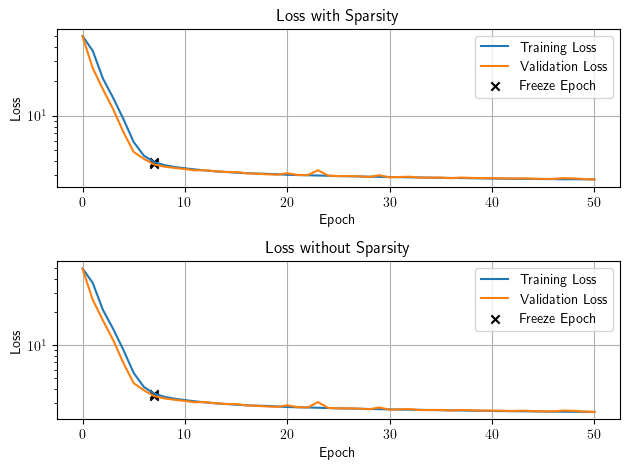

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["text.usetex"] = True

fig, ax = plt.subplots(2, 1)
ax[0].plot(
    np.arange(0, len(Loss_1_Training_History)),
    Loss_1_Training_History,
    label="Training Loss",
)
ax[0].plot(
    np.arange(0, len(Loss_1_Validation_History)),
    Loss_1_Validation_History,
    label="Validation Loss",
)
ax[0].scatter(
    [freeze_epoch, freeze_epoch],
    [
        Loss_1_Training_History[freeze_epoch],
        Loss_1_Validation_History[freeze_epoch],
    ],
    label="Freeze Epoch",
    color="black",
    marker="x",
)
ax[0].set_title("Loss with Sparsity")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_yscale("log")
ax[0].legend()
ax[0].grid()

ax[1].plot(
    np.arange(0, len(Loss_2_Training_History)),
    Loss_2_Training_History,
    label="Training Loss",
)
ax[1].plot(
    np.arange(0, len(Loss_2_Validation_History)),
    Loss_2_Validation_History,
    label="Validation Loss",
)
ax[1].scatter(
    [freeze_epoch, freeze_epoch],
    [
        Loss_2_Training_History[freeze_epoch],
        Loss_2_Validation_History[freeze_epoch],
    ],
    label="Freeze Epoch",
    color="black",
    marker="x",
)
ax[1].set_title("Loss without Sparsity")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_yscale("log")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

Final loss.

In [28]:
Loss_2_Validation_History[-1]

tensor(2.4895)

Linear Mapping Matrix Visualization.

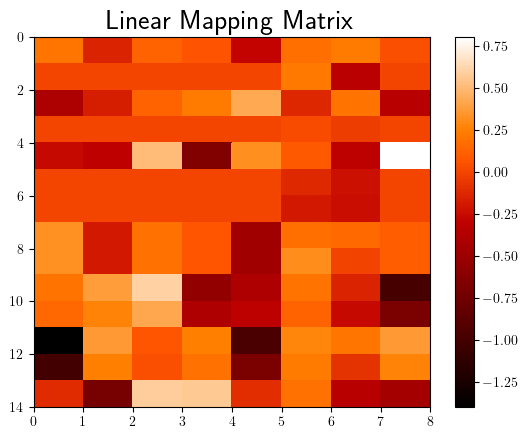

In [29]:
plt.pcolor(Net.LinearMapping.weight.detach().to("cpu").numpy(), cmap="gist_heat")
plt.colorbar()
plt.gca().invert_yaxis()
plt.title("Linear Mapping Matrix", fontsize=20)
plt.show()

Linear Layer Weight Visualization.

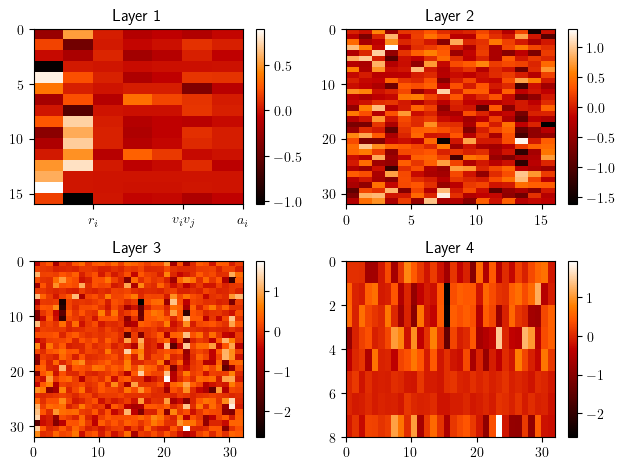

In [30]:
fig, ax = plt.subplots(2, 2)
Layer_1_Visualization = ax[0, 0].pcolor(
    Net.layer_1.weight.detach().to("cpu").numpy(), cmap="gist_heat"
)
ax[0, 0].invert_yaxis()
ax[0, 0].set_title("Layer 1")
ax[0, 0].set_xticks([2, 5, 7])
ax[0, 0].set_xticklabels([r"$r_i$", r"$v_i v_j$", r"$a_i$"])
fig.colorbar(Layer_1_Visualization)

Layer_2_Visualization = ax[0, 1].pcolor(
    Net.layer_2.weight.detach().to("cpu").numpy(), cmap="gist_heat"
)
ax[0, 1].invert_yaxis()
ax[0, 1].set_title("Layer 2")
fig.colorbar(Layer_2_Visualization)

Layer_3_Visualization = ax[1, 0].pcolor(
    Net.layer_3.weight.detach().to("cpu").numpy(), cmap="gist_heat"
)
ax[1, 0].invert_yaxis()
ax[1, 0].set_title("Layer 3")
fig.colorbar(Layer_3_Visualization)

Layer_4_Visualization = ax[1, 1].pcolor(
    Net.layer_4.weight.detach().to("cpu").numpy(), cmap="gist_heat"
)
ax[1, 1].invert_yaxis()
ax[1, 1].set_title("Layer 4")
fig.colorbar(Layer_4_Visualization)

plt.tight_layout()
plt.show()